# Main Notebook to Perform Trading

### Imports

In [20]:
from data_collection import get_historical_data
from pair_finder import find_high_corr_pairs
from pair_trading import engle_granger_test, get_ratio, compute_zscore
from testing import (
    generate_positions, 
    backtest_pair_with_capital, 
    plot_backtest_results
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Getting Data

In [37]:
# Define the ticker list
# Always include "SPY" to benchmark vs. S&P
tickers = [
    # Technology
    "AAPL",  # Apple (tech)
    "MSFT",  # Microsoft (tech)
    "GOOG",  # Alphabet (tech)
    "AMZN",  # Amazon (e-commerce/tech)
    "META",  # Meta (Facebook)
    "NVDA",  # NVIDIA (semiconductors)
    "IBM",   # IBM (enterprise tech)
    "ORCL",  # Oracle (enterprise tech)
    "INTC",  # Intel (semiconductors)
    "ADBE",  # Adobe (software)
    "CRM",   # Salesforce (enterprise software)

    # Consumer Goods & Retail
    "KO",    # Coca-Cola (beverage)
    "PEP",   # PepsiCo (beverage/food)
    "WMT",   # Walmart (retail)
    "COST",  # Costco (retail)
    "PG",    # Procter & Gamble (consumer goods)

    # Healthcare
    "JNJ",   # Johnson & Johnson (healthcare)

    # Financials
    "GS",    # Goldman Sachs (banking)

    # Automotive & Clean Energy
    "TSLA",  # Tesla (EV/clean energy)

    # Entertainment & Media
    "NFLX",  # Netflix (streaming)
    "DIS",   # Disney (entertainment)

    # Food & Beverage
    "MCD",   # McDonald's (fast food)
    "SBUX",  # Starbucks (coffee)

    # Aerospace
    "BA",    # Boeing (aerospace)

    # Benchmark
    "SPY"    # S&P 500 (benchmark)
]

start_date = "2023-12-31"
end_date   = "2024-12-31"
historical_data = get_historical_data(tickers, start=start_date, end=end_date)

print("Historical Data Shape:", historical_data.shape)
display(historical_data.tail())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Historical Data Shape: (251, 25)


,AAPL,MSFT,GOOG,AMZN,META,NVDA,IBM,ORCL,INTC,ADBE,CRM,KO,PEP,WMT,COST,PG,JNJ,GS,TSLA,NFLX,DIS,MCD,SBUX,BA,SPY
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2024-12-23,255.270004,435.250000,195.990005,225.059998,599.849976,139.669998,221.929993,168.725281,20.200001,446.739990,342.899994,62.380001,151.289993,90.349998,949.909973,168.110001,145.270004,570.780029,430.600006,911.450012,111.400002,291.290009,87.440002,177.690002,594.690002
2024-12-24,258.200012,439.329987,197.570007,229.050003,607.750000,140.220001,224.410004,170.989731,20.400000,447.940002,344.429993,62.840000,152.809998,92.680000,958.820007,168.940002,145.850006,582.789978,462.279999,932.119995,112.559998,293.989990,89.910004,179.339996,601.299988
2024-12-26,259.019989,438.109985,197.100006,227.050003,603.349976,139.929993,224.889999,171.259048,20.440001,450.160004,341.720001,62.570000,152.440002,92.790001,956.140015,170.160004,145.580002,581.229980,454.130005,924.140015,112.550003,294.799988,91.860001,180.380005,601.340027
2024-12-27,255.589996,430.529999,194.039993,223.750000,599.809998,137.009995,222.779999,168.545731,20.299999,446.480011,338.450012,62.450001,152.889999,91.660004,939.700012,169.529999,145.050003,576.179993,431.660004,907.549988,111.550003,293.619995,92.250000,180.720001,595.010010
2024-12-30,252.199997,424.829987,192.690002,221.300003,591.239990,137.490005,220.250000,166.500763,19.820000,445.799988,335.739990,62.029999,151.720001,90.570000,922.210022,167.089996,143.339996,573.549988,417.410004,900.429993,110.800003,289.600006,90.580002,176.550003,588.219971


### Find and Pick Pairs

In [32]:
non_spy_data = historical_data.drop(columns=["SPY"], errors='ignore')

high_corr_df = find_high_corr_pairs(
    non_spy_data, 
    corr_threshold=0.8,
    value_diff_threshold=0.01
)

print("High Correlation Pairs (above 0.8 corr):")
display(high_corr_df)

High Correlation Pairs (above 0.8 corr):


,Stock 1,Stock 2,Correlation
0,NVDA,WMT,0.879480
1,NVDA,ORCL,0.876157


In [33]:
top_3_pairs = high_corr_df.head(3)
print("Top 3 pairs:")
display(top_3_pairs)

Top 3 pairs:


,Stock 1,Stock 2,Correlation
0,NVDA,WMT,0.879480
1,NVDA,ORCL,0.876157


In [34]:
# always compare to SPY
spy_series = historical_data["SPY"].dropna()

### Compute Statistics and Perform Backtesting

In [39]:
def run_pair_backtest(historical_data, stock1_name, stock2_name, spy_series, correlation=None,
                      initial_capital=10000.0, z_entry=1.0, z_exit=0.0):
    """
    Runs the full backtest process for a single pair: (stock1_name, stock2_name).
    
    Steps:
      1) Extract time series from historical_data
      2) Cointegration test
      3) Compute ratio & z-score
      4) Generate positions based on zscore
      5) Backtest with initial capital vs. SPY
    
    Returns:
      A DataFrame containing 'Strategy_Capital', 'SPY_BuyHold', 'Pos'
    """

    # Print pair info
    if correlation is not None:
        print(f"--- Backtesting Pair: {stock1_name} vs. {stock2_name}, Corr={correlation:.2f} ---")
    else:
        print(f"--- Backtesting Pair: {stock1_name} vs. {stock2_name} ---")
    
    # 1) Extract each stock's price series
    stock1_series = historical_data[stock1_name].dropna()
    stock2_series = historical_data[stock2_name].dropna()
    
    # 2) Perform Engle-Granger cointegration test
    coint_res = engle_granger_test(stock1_series, stock2_series)
    print(f"Cointegration p-value: {coint_res['p_value']:.4f}")
    
    # 3) Compute ratio & z-score
    ratio = get_ratio(stock1_series, stock2_series)
    zscore_20_5 = compute_zscore(ratio, short_window=5, long_window=20)
    
    # 4) Generate positions
    positions = generate_positions(zscore_20_5, z_entry=z_entry, z_exit=z_exit)
    
    # 5) Run backtest with \$10k initial capital
    backtest_df = backtest_pair_with_capital(
        stock1_series, 
        stock2_series, 
        positions, 
        spy_series, 
        initial_capital=initial_capital
    )

    print("\n")
    return backtest_df

--- Backtesting Pair: NVDA vs. WMT, Corr=0.88 ---
Cointegration p-value: 0.2806


--- Backtesting Pair: NVDA vs. ORCL, Corr=0.88 ---
Cointegration p-value: 0.3799




c:\Users\Arjun\pairs_trading\testing.py:96: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  spy_aligned = spy_series.loc[df.index].fillna(method='ffill')
c:\Users\Arjun\pairs_trading\testing.py:96: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  spy_aligned = spy_series.loc[df.index].fillna(method='ffill')


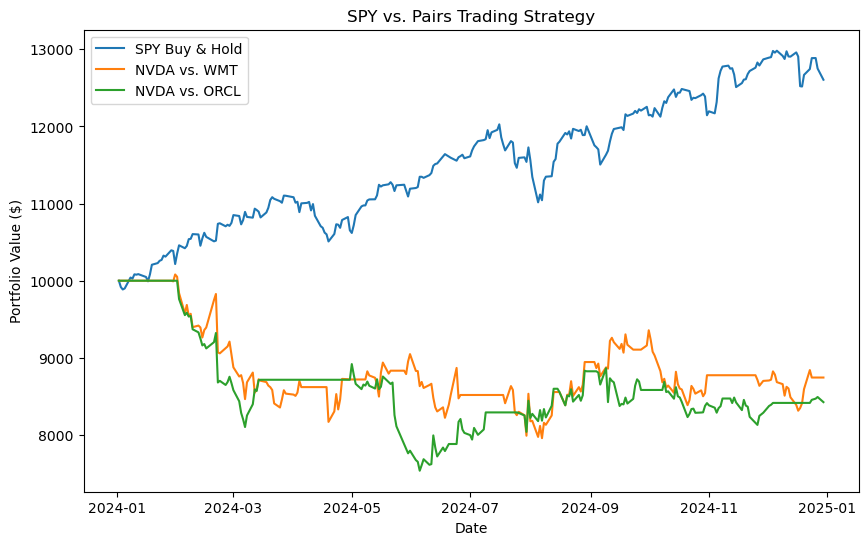

In [43]:
# Create a list to hold (pair_label, backtest_df) for each pair
all_backtests = []

#Loop over the top 3 pairs and collect backtest results
for i, row in top_3_pairs.iterrows():
    s1 = row["Stock 1"]
    s2 = row["Stock 2"]
    corr_val = row["Correlation"]
    
    # Call your run_pair_backtest but remove the final plotting from inside it 
    # (or comment it out), so we only collect the DataFrame.
    bt_df = run_pair_backtest(
        historical_data=historical_data,
        stock1_name=s1,
        stock2_name=s2,
        spy_series=spy_series,
        correlation=corr_val,
        initial_capital=10000.0,
        z_entry=1.0,
        z_exit=0.0
    )
    # Save label and df
    pair_label = f"{s1} vs. {s2}"
    all_backtests.append((pair_label, bt_df))

# After loop, plot SPY and each pair's capital on a single graph
fig, ax = plt.subplots(figsize=(10, 6))

# assume the first DataFrame in all_backtests has the needed SPY_BuyHold
ax.plot(
    all_backtests[0][1].index,
    all_backtests[0][1]['SPY_BuyHold'],
    label='SPY Buy & Hold'
)

for label, df in all_backtests:
    ax.plot(df.index, df['Strategy_Capital'], label=label)

ax.set_title('SPY vs. Pairs Trading Strategy')
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value ($)')
ax.legend()
plt.show()